In [1]:
import io

import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib import gridspec, patches
import numpy as np
import os
from xml.etree import ElementTree
from PIL import Image

In [2]:
class LabeledImage:
  def __init__(self):
    self.image_path = ""
    self.labels = []

class PKDataset:
  def __init__(self, root):
    self.images = []
    self.labels = []
    self.image_metadata = []
    for filename in os.scandir(root):
      #Ignore top level files
      if filename.is_dir():
        self.load_dir(filename)

  def load_dir(self, directory: os.DirEntry):
    for entry in os.scandir(directory):
      if entry.is_file():
        if entry.name.endswith('.jpg'):
          #Labels are the directory names, except for the file name
          labels: [str] = entry.path.split(os.sep)
          #Filename
          labels.pop(-1)
          #Misc directories that aren't labels
          not_labels = ["PKLot", "PkLot", ".", "PKLotSegmented"]
          for not_label in not_labels:
            try:
              labels.remove(not_label)
            except ValueError:
              continue
          labels = set(labels)
          self.images.append(entry)
          self.labels.append(labels)
          metadata_file = entry.path.replace(".jpg", ".xml")
          self.image_metadata.append(metadata_file)
          # just make sure that the labels and entries match up
          assert len(self.images) == len(self.labels)
      elif entry.is_dir():
        self.load_dir(entry)

  def __len__(self):
    return len(self.images)

  #Loads images from FS rather than from memory
  def __getitem__(self, index):
    file = open(self.images[index].path, mode='rb')
    image = file.read()
    return Image.open(io.BytesIO(image)), self.labels[index]

  def get_metadata(self, index):
    return self.image_metadata[index]

In [3]:
transform = torch.nn.Sequential(T.Resize((720, 1280)))
pk_test = PKDataset('./PKLot/PkLot')
pk_train = PKDataset('./PKLot/PKLotSegmented')
pk_images = torch.utils.data.DataLoader(pk_test, batch_size=4, pin_memory=True)

0; 0
1; 0
2; 17
3; 40
4; 40
5; 30
6; 40
7; 37
8; 40
9; 27
10; 32
11; 40


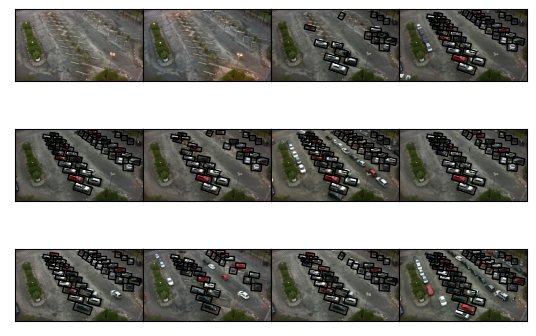

{'Empty', 'Cloudy', 'UFPR05', '2013-03-16'}


In [5]:
nrow = 3
ncol = 4
gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for i in range(0, nrow):
  for j in range(0, ncol):
    ax = plt.subplot(gs[i, j])
    plt.xticks([])
    plt.yticks([])
    ax.imshow(pk_test[(i*ncol + j)*20][0])
    doc = ElementTree.parse(pk_test.get_metadata((i*ncol + j)*20))
    occupied = 0
    for space in doc.getroot().iter('space'):
      occupied += int(space.get('occupied'))
      if int(space.get('occupied')) > 0:
        rect = space.find('rotatedRect')
        center = rect.find('center')
        size = rect.find('size')
        angle = rect.find('angle')
        bottom_left_x = int(center.get("x")) - (int(size.get("w")) / 2)
        bottom_left_y = int(center.get("y")) - (int(size.get("h")) / 2)
        ax.add_patch(patches.Rectangle(xy = (bottom_left_x, bottom_left_y),
                                       width=int(size.get("w")),
                                       height=int(size.get("h")),
                                       angle=float(angle.get("d")),
                                       rotation_point="center",
                                       fill=False))
    print(f"{(i*ncol + j)}; {occupied}".format())
plt.show()
print(pk_train[0][1])

SyntaxError: invalid syntax (650692435.py, line 2)